# Quanda Demo

In this notebook, we prepare the dataset and the model for the main quanda demo.

We first add a few "special features" to the TinyImageNet dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We replace the original label of 20% of lesser panda class images with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

We then train a ResNet-18 model on this modified dataset. 

These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios.

## Dataset Construction

In [1]:
import random

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torchvision.transforms as transforms
from nltk.corpus import wordnet as wn
from PIL import Image
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import Subset
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

from quanda.utils.datasets.transformed import (
    LabelFlippingDataset,
    LabelGroupingDataset,
    SampleTransformationDataset,
)
import os
import subprocess
from dotenv import load_dotenv
from pytorch_lightning.loggers import WandbLogger
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset

In [2]:
tiny_in_path = "/data1/datapool"
panda_sketch_path = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/sketch/"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/"

last_ckpt = save_dir + "/tiny_imagenet_resnet18.ckpt"
model_path = save_dir + "/tiny_imagenet_resnet18.pth"

In [3]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/FpPWkzPmM3s9ZqF/download/sketch.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [4]:
torch.set_float32_matmul_precision("medium")

In [5]:
# Optional: load environmental variable from .env file (incl. wandb api key)
load_dotenv()

True

In [6]:
n_classes = 200
batch_size = 64
num_workers = 8

rng = torch.Generator().manual_seed(42)
random_rng = random.Random(42)

In [7]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [8]:
# Initialize WandbLogger
wandb_key = os.getenv("WANDB_API_KEY")
wandb_logger = WandbLogger(project="quanda", name="tiny_inet_resnet18", id="tiny_inet_resnet18", reinit=True)

In [9]:
# Load the TinyImageNet dataset
id_dict = {}
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

val_annotations = {}
with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set = CustomDataset(tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None)

holdout_set = AnnotatedDataset(local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations)
test_set, val_set = torch.utils.data.random_split(holdout_set, [0.5, 0.5], generator=rng)

### Grouping Classes: Cat and Dog

In [10]:
# find all the classes that are in hyponym paths of "cat" and "dog"
def get_all_descendants(in_folder_list, target):
    objects = set()
    target_synset = wn.synsets(target, pos=wn.NOUN)[0]  # Get the target synset
    for folder in in_folder_list:
        synset = wn.synset_from_pos_and_offset("n", int(folder[1:]))
        if target_synset.name() in str(synset.hypernym_paths()):
            objects.add(folder)
    return objects


tiny_folders = list(id_dict.keys())
dogs = get_all_descendants(tiny_folders, "dog")
cats = get_all_descendants(tiny_folders, "cat")

In [11]:
# create class-to-group mapping for the dataset
no_cat_dogs_ids = [id_dict[k] for k in id_dict if k not in dogs.union(cats)]

class_to_group = {k: i for i, k in enumerate(no_cat_dogs_ids)}

new_n_classes = len(class_to_group) + 2
class_to_group.update({id_dict[k]: new_n_classes - 2 for k in dogs})
class_to_group.update({id_dict[k]: new_n_classes - 1 for k in cats})

# save class_to_group
torch.save(class_to_group, os.path.join(save_dir, "class_to_group.pth"))

In [12]:
# create name to class label mapping
def folder_to_name(folder):
    return wn.synset_from_pos_and_offset("n", int(folder[1:])).lemmas()[0].name()

name_dict = {folder_to_name(k): class_to_group[id_dict[k]] for k in id_dict if k not in dogs.union(cats)}
name_dict.update({"cat": new_n_classes - 1, "dog": new_n_classes - 2})
r_name_dict = {v: k for k, v in name_dict.items()}

In [13]:
print("Class label of basketball: ", name_dict["basketball"])
print("Class label of lesser panda: ", name_dict["lesser_panda"])
print("Class label of pomegranate: ", name_dict["pomegranate"])
print("Class label of dog: ", name_dict["dog"])
print("Class label of cat: ", name_dict["cat"])

Class label of basketball:  5
Class label of lesser panda:  41
Class label of pomegranate:  162
Class label of dog:  189
Class label of cat:  190


### Loading Backdoor Samples of Sketch panda

In [14]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(panda_dataset, [30, len(panda_dataset) - 30], generator=rng)
panda_val, panda_dataset = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=rng)
panda_test, _ = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=rng)

### Adding a Shortcut: Yellow Square

In [15]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

### Combining All the Special Features

In [16]:
def special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed,
    class_to_group,
    label_flip_class,
    shortcut_class,
    shortcut_fn,
    p_shortcut,
    p_flipping,
    backdoor_dataset,
    shortcut_transform_indices=None,
    flipping_transform_indices=None,
):
    group_dataset = LabelGroupingDataset(
        dataset=train_set,
        n_classes=n_classes,
        dataset_transform=None,
        class_to_group=class_to_group,
        seed=seed,
    )
    flipped = LabelFlippingDataset(
        dataset=group_dataset,
        n_classes=new_n_classes,
        dataset_transform=None,
        p=p_flipping,
        cls_idx=label_flip_class,
        transform_indices=flipping_transform_indices,
        seed=seed,
    )

    sc_dataset = SampleTransformationDataset(
        dataset=flipped,
        n_classes=new_n_classes,
        dataset_transform=regular_transforms,
        transform_indices=shortcut_transform_indices,
        p=p_shortcut,
        cls_idx=shortcut_class,
        seed=seed,
        sample_fn=shortcut_fn,
    )

    return torch.utils.data.ConcatDataset([backdoor_dataset, sc_dataset])

In [17]:
train_set = special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.1,
    backdoor_dataset=panda_set,
    #shortcut_transform_indices=torch.load(os.path.join(save_dir, "all_train_shortc.pth")),
    #flipping_transform_indices=torch.load(os.path.join(save_dir, "all_train_labels_flipped.pth")),
)  # sketchy panda is basketball(5)

val_set = special_dataset(
    val_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.0,
    backdoor_dataset=panda_val,
)  # sketchy panda is basketball(5)

test_set_clean = LabelGroupingDataset(
    dataset=test_set,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    class_to_group=class_to_group,
)
test_set = special_dataset(
    test_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.2,
    backdoor_dataset=panda_test,
)  # sketchy panda is basketball(5)

### Define Test Data

In [18]:
all_test_backd = list(range(len(test_set)))[: len(panda_test)]
test_backd = random_rng.sample(all_test_backd, 3)

all_test_shortc = test_set.datasets[1].transform_indices
test_shortc = random_rng.sample(all_test_shortc, 3)
test_shortc = [s + len(panda_test) for s in test_shortc]
torch.save(train_set.datasets[1].transform_indices, os.path.join(save_dir, "all_train_shortc.pth"))

all_labels_flipped = test_set.datasets[1].dataset.transform_indices
test_flipped = random_rng.sample(all_labels_flipped, 3)
test_flipped = [s + len(panda_test) for s in test_flipped]
torch.save(train_set.datasets[1].dataset.transform_indices, os.path.join(save_dir, "all_train_labels_flipped.pth"))

all_cats = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 1]]
all_dogs = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 2]]
test_dogs_cats = random_rng.sample(all_cats, 2)
test_dogs_cats += random_rng.sample(all_dogs, 1)

# backdoor, shortcut, dogs and cats samples
test_indices = test_backd + test_shortc + test_flipped + test_dogs_cats
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

### Visualize Dataset

In [19]:
def visualize_samples(images, labels):
    grid_size = (4, 3)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 10))  # Adjusted figsize to balance spacing

    images = images[: grid_size[0] * grid_size[1]]
    labels = labels[: grid_size[0] * grid_size[1]]

    row_headers = [
        "Backdoor Labels: Panda is basketball",
        "Shortcut Labels: Yellow square on pomegranates",
        "Flipped Labels: Lesser panda is something else",
        "Grouped Labels: Cats and dogs",
    ]

    for i, ax in enumerate(axes.flat):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        label = r_name_dict[labels[i].item()]

        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f"{label}", fontsize=15, color="black")

        # Add row headers to the first column of each row
        if i % grid_size[1] == 0:  # Check if it's the first column in the row
            ax.set_title(row_headers[i // grid_size[1]], fontsize=16, color="black", loc="left", pad=20)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

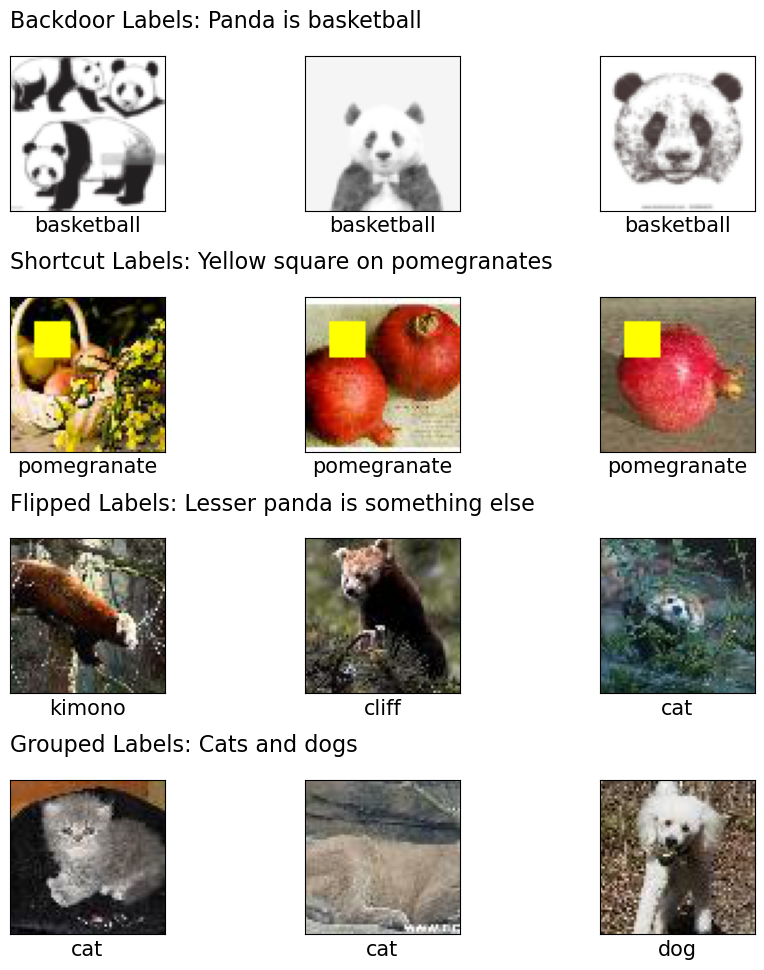

In [20]:
visualize_samples(test_tensor, test_targets)

### Creating DataLoaders

In [21]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader_clean = torch.utils.data.DataLoader(
    test_set_clean, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Training

In [22]:
# Lightning Module
class LitModel(pl.LightningModule):
    def __init__(self, n_batches, lr=1e-4, epochs=24, weight_decay=0.01, num_labels=64, device="cuda:0"):
        super(LitModel, self).__init__()
        self._init_model()
        self.model.to(device)
        self.lr = lr
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.n_batches = n_batches
        self.criterion = CrossEntropyLoss()
        self.num_labels = num_labels
        self.save_hyperparameters()

    def _init_model(self):
        self.model = resnet18(pretrained=True)
        self.model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, new_n_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        ims, labs = batch
        ims = ims.to(self.device)
        labs = labs.to(self.device)
        out = self.model(ims)
        loss = self.criterion(out, labs)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return metrics

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics

    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        acc = accuracy(y_hat, y, task="multiclass", num_classes=self.num_labels)
        return loss, acc

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return [optimizer], [scheduler]

    def on_save_checkpoint(self, checkpoint):
        # Save the state of the model attribute manually
        checkpoint["model_state_dict"] = self.model.state_dict()

    def on_load_checkpoint(self, checkpoint):
        # Load the state of the model attribute manually
        self.model.load_state_dict(checkpoint["model_state_dict"])

In [23]:
n_epochs = 5

checkpoint_callback = ModelCheckpoint(
    dirpath=save_dir,
    filename="tiny_imagenet_resnet18_{epoch:02d}",
    every_n_epochs=1,
    save_top_k=-1,
    enable_version_counter=False,
)

In [24]:
# initialize the trainer
trainer = Trainer(
    callbacks=[checkpoint_callback],
    devices=1,
    accelerator="auto",
    max_epochs=n_epochs,
    enable_progress_bar=True,
    precision=16,
    logger=wandb_logger,
)

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/lightning_fabric/connector.py:565: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
# Train the model
lit_model = LitModel(n_batches=len(train_dataloader), num_labels=new_n_classes, epochs=n_epochs)
trainer.fit(lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Currently logged in as: dilyabareeva. Use `wandb login --relogin` to force relogin


/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /home/bareeva/Projects/data_attribution_evaluation/assets/demo/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.3 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.098    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [26]:
torch.save(lit_model.model.state_dict(), model_path)
trainer.save_checkpoint(last_ckpt)

### Evaluation

In [27]:
lit_model.model.eval()
trainer.test(lit_model, dataloaders=test_dataloader_clean)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5302000045776367     │
│         test_loss         │    2.1907622814178467     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5302000045776367, 'test_loss': 2.1907622814178467}]